<a href="https://colab.research.google.com/github/Daniele-Di-Bella/ER_glycoforms_fates_modelling/blob/main/ER_Glycoforms_Fates_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Glycoforms fates modelling**

## **Conditions**
### **Entities**
- **Single N-glycan per protein**: the model doesn't account for proteins with multiple glycosylation sites;

- **The model represents glycoforms as a finite list of labelled species**  

- **Lectin-bound species are represented as separate species prefixed by `CNX_` or `OS9_`**: `X` ≠ `CNX_X` ≠ `OS9_X`.

- **No spatial compartments beyond ER lumen and a single `SEC` pool.** There is no Golgi compartment modelled; `SEC` is an accumulating sink that stands for secreted material (presumably reaching Golgi and beyond). No compartment-specific kinetics or transport delays are modelled.

### **Conservation and algebraic constraints**
- **Initial condition: all M9 and kifunensine inhibition.** We are imagining a scenario in which the synthesis of new protein in the cell has been inhibited through the use of kifunensine, therefore, the total tracked mass (1.0 µM) does not vary. Moreover, in this scenario the total tracked mass is initially composed only by proteins possessing the glycoform `M9`, which will have different fates. That's why all concentrations start at 0 µM except `M9 = 1.0 µM`.

- **CNX and OS9 total pools are conserved and treated algebraically.**: lectin pools are fixed totals; binding/unbinding only redistributes between free and bound forms, and total CNX/OS9 never changes.

- **Degraded mass is derived, not a tracked species.** The code computes `total = free_sum + CNX_sum + OS9_sum + SEC` and then `degraded = 1.0 - total`. There is no explicit `DEG` state variable in the ODEs. Degraded mass is whatever has left the tracked pools.

### **Kinetic laws and enzyme modelling**
- **All reactions are mass-action style and linear in substrate; enzyme effects are modelled by multiplying a fixed enzyme pool by a rate constant.** Each enzymatic step is `v = enzyme_pool * k_constant * [substrate]`. There is no explicit enzyme–substrate complex, no saturation, and no cooperative kinetics. Enzyme concentration scales reaction rates linearly.

- **Enzyme abundances are constant parameters (not dynamic).** Enzymes `UGGT, GII, ERManI, EDEM1, EDEM2, EDEM3, EREM` are provided as fixed µM pools in `params`. They do not change during simulation. Enzyme regulation, synthesis, degradation or sequestration are not included; simulated perturbations are implemented by setting k constants to zero.

- **UGGT and GII select free species only.** UGGT/GII actions are restricted to the `free` pool, so CNX-bound or OS9-bound glycoforms are not glucosylated or deglycosylated.

- **ERManI and EDEM2 target N-glycan branch B; EDEM1 and EDEM3 target branches A and C.** Multiple mannosidases can catalyze overlapping transformations but with different rate constants.

- **ER-EM acts on glucosylated species (G1...) and directly converts them to trimmed non-glucosylated products.** The recent publication of [this paper](https://pubmed.ncbi.nlm.nih.gov/41100884/) pushed us to take into account the presence of an additional enzyme called with the general name ER-EM (Endoplasmic Reticulum EndoMannosidase), `EREM`, in the code. `EREM` is modelled as a free enzyme that directly hydrolyses glucosylated glycans in a single step. There is no explicit mechanistic coupling (e.g., complex formation) between UGGT and EREM in the code.

### **Secretion and sinks**
- **Secretion applies only to free glycoforms and with equal rate constant.** The code loops over `free` and applies `v_sec = k_secretion * [s]`, removing it from each free species and adding to `SEC`. There is no dependence on glycoform identity: all free species have the same per-concentration secretion probability. Species-specific secretion signals or lectin protection from secretion (except indirectly via their concentration being in bound pools) are not modelled; secretion is purely concentration-driven for the free pool.

- **ERAD sink acts only on OS9-bound species.** There is no sink on free species or CNX-bound species; only `OS9_<s>` loses mass via `k_ERAD_sink`. OS9 binding is the gate to degradation; escaping OS9 or failing to bind can result in secretion or further trimming instead.

### **Solver assumptions**
- **Numerical integration is performed with `solve_ivp`.** The solver is expected to handle stiff-ish dynamics but there is no explicit solver selection. The time insterval considered, `t_eval`, is a log-spaced vector from `t_start = 1e0` to `t_end = 1e5`. The integration interval passed to the solver starts at `0.0` but `t_eval` avoids t=0 to allow a log x-axis. The log-spaced output emphasizes early-time dynamics.
  
### **Experimental perturbations implemented in the code**
- **Four experimental conditions (A–D) are implemented by zeroing rate constants.**  
  - **A: Uninhibited** — baseline params.  
  - **B: UGGT inhibited** — all `k_UGGT_...` rate constants set to `0.0`. This zeroes glucosylation rates (UGGT catalytic constants), effectively removing UGGT activity. The code leaves `UGGT` pool unchanged but makes its catalytic constants zero.  
  - **C: Mannosidases inhibited** — all keys starting with `k_ERManI_`, `k_EDEM1_`, `k_EDEM2_`, `k_EDEM3_`, and `k_EREM_` set to `0.0` (ERManI/EDEM family and EREM are disabled).  
  - **D: UGGT + Mannosidases inhibited** — merges B and C: UGGT and all ERManI/EDEM/EREM constants are zero.

## **Implementation**

In [49]:
# General imports. Run always this cell

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import networkx as nx

from scipy.integrate import solve_ivp
from scipy.cluster.hierarchy import linkage, leaves_list
from collections import defaultdict
from matplotlib import rcParams, cm
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

### **1. Initialization of parameters**

In [50]:
# ----------------------------
# 1a) Context
# ----------------------------

# All the glycospecies that can be found on proteins free in the ER lumen
free = ["G1M9","G1M8B","G1M8C","M9","M8A","M8B","M8C", "M7AB","M7BC","G1M7BC","M7AC","M6","M5"]

# CNX-binding species
cnx_bind = ["G1M9","G1M8B","G1M8C","G1M7BC"]

# OS9-binding species
os9_bind = ["M8C","M7AC","M7BC","M6","M5","G1M8C","G1M7BC"]

# Everything that can be found in ER lumen (according to previous initializations)
full_ER = (
    free                              # free glycoproteins
    + [f"CNX_{s}" for s in cnx_bind]  # glycoproteins bound to CNX -> ERQC
    + [f"OS9_{s}" for s in os9_bind]  # glycoproteins bound to OS9 -> ERAD
    + ["SEC"]                         # accumulated secreted pool
)
name_to_index = {n:i for i,n in enumerate(full_ER)}

# ----------------------------
# 1b) Initial condition and parameters
# ----------------------------

# Initial condition: Everything is set on 0 µM except from [M9] = 1.0 µM
y0 = np.zeros(len(full_ER), dtype=float)
y0[name_to_index["M9"]] = 1.0

# Parameters
params = {
    # enzyme pools (µM)
    "UGGT": 0.2, "GII": 0.5, "EREM": 0.75, "ERManI": 0.4,
    "EDEM1": 0.15, "EDEM2": 0.15, "EDEM3": 0.15,
    "CNX_tot": 3.0, "OS9_tot": 0.8,

    # binding kinetics (M^-1 * s^-1, s^-1)
    "kon_CNX": 0.3, "koff_CNX": 0.05,
    "kon_OS9": 0.2, "koff_OS9": 0.03,

    # sinks and secretion (s^-1)
    "k_ERAD_sink": 0.001,
    "k_secretion": 0.001,

    # UGGT (adds glucose, M^-1 s^-1)
    "k_UGGT_G1M9": 0.016, "k_UGGT_G1M8B": 0.016,
    "k_UGGT_G1M8C": 0.016, "k_UGGT_G1M7BC": 0.016,

    # GII (removes glucose, M^-1 s^-1)
    "k_GII_M9": 0.004, "k_GII_M8B": 0.004,
    "k_GII_M8C": 0.004, "k_GII_M7BC": 0.004,

    # ERManI (acts on N-glycan Branch B, M^-1 s^-1)
    "k_ERManI_M8B": 0.012, "k_ERManI_G1M8B": 0.012,
    "k_ERManI_M7BC": 0.012, "k_ERManI_G1M7BC": 0.012,
    "k_ERManI_M7AB": 0.012, "k_ERManI_M6": 0.012,

    # EDEM2 (acts on N-glycan Branch B, M^-1 s^-1)
    "k_EDEM2_M8B": 0.006, "k_EDEM2_G1M8B": 0.006,
    "k_EDEM2_M7BC": 0.006, "k_EDEM2_G1M7BC": 0.006,
    "k_EDEM2_M7AB": 0.006, "k_EDEM2_M6": 0.006,

    # EDEM1 (acts on N-glycan Branches A and C, M^-1 s^-1)
    "k_EDEM1_M8A": 0.006, "k_EDEM1_M7AB": 0.006,
    "k_EDEM1_M6_from_M7BC": 0.006, "k_EDEM1_M7AC": 0.006,
    "k_EDEM1_M5": 0.006, "k_EDEM1_M8C": 0.006,
    "k_EDEM1_M7BC": 0.006, "k_EDEM1_M6_from_M7AB": 0.006,
    "k_EDEM1_M7AC_from_M8A": 0.006,

    # EDEM3 (acts on N-glycan Branches A and C, M^-1 s^-1)
    "k_EDEM3_M8A": 0.006, "k_EDEM3_M7AB": 0.006,
    "k_EDEM3_M6_from_M7BC": 0.006, "k_EDEM3_M7AC": 0.006,
    "k_EDEM3_M5": 0.006, "k_EDEM3_M8C": 0.006,
    "k_EDEM3_M7BC": 0.006, "k_EDEM3_M6_from_M7AB": 0.006,
    "k_EDEM3_M7AC_from_M8A": 0.006,

    # EREM (acts on Glu-Man bonds, µM^-1 s^-1)
    "k_EREM_M8A": 0.2,     # G1M9 -> M8A
    "k_EREM_M7AB": 0.02,    # G1M8B -> M7AB
    "k_EREM_M7AC": 0.02,    # G1M8C -> M7AC
    "k_EREM_M6": 0.02,   # G1M7BC -> M6
}

### **2. Initialization of ODE system**

In [51]:
def ode_rhs(t: float, y: np.ndarray, p: dict) -> np.ndarray:
    dy = np.zeros_like(y)
    g = lambda s: y[name_to_index[s]]  # gets the index of an item and locate it in y
    add = lambda s, v: dy.__setitem__(name_to_index[s], dy[name_to_index[s]] + v)  # add a value to a certain element in dy

    # Free lectin pools (algebraic approach)
    CNX_free = p["CNX_tot"] - sum(g(f"CNX_{s}") for s in cnx_bind)
    OS9_free = p["OS9_tot"] - sum(g(f"OS9_{s}") for s in os9_bind)

    # CNX binding/unbinding
    for s in cnx_bind:
        bind = p["kon_CNX"] * g(s) * CNX_free
        unbd = p["koff_CNX"] * g(f"CNX_{s}")
        add(s, -bind + unbd)
        add(f"CNX_{s}", +bind - unbd)

    # OS9 binding/unbinding + ERAD sink from OS9‐bound
    for s in os9_bind:
        bind = p["kon_OS9"] * g(s) * OS9_free
        unbd = p["koff_OS9"] * g(f"OS9_{s}")
        erad = p["k_ERAD_sink"] * g(f"OS9_{s}")
        add(s, -bind + unbd)
        add(f"OS9_{s}", +bind - unbd - erad)

    # Secretion of free glycoproteins (equal probability for all free glycoforms)
    ksec = p.get("k_secretion", 0.0)
    if ksec > 0:
        for s in free:
            v_sec = ksec * g(s)
            add(s, -v_sec)
            add("SEC", +v_sec)

    # Enzymatic transformations (UGGT, GII, mannosidases, EREM etc.)
    UGGT = p["UGGT"]; GII = p["GII"]
    ERManI = p["ERManI"]; EDEM1 = p["EDEM1"]
    EDEM2 = p["EDEM2"]; EDEM3 = p["EDEM3"]
    EREM = p.get("EREM", 0.0)

    def bi(pool, k): return pool * k

    # UGGT steps (glucosylation of free forms)
    v = bi(UGGT, p["k_UGGT_G1M9"]) * g("M9");           add("M9",-v);    add("G1M9",+v)
    v = bi(UGGT, p["k_UGGT_G1M8B"]) * g("M8B");         add("M8B",-v);   add("G1M8B",+v)
    v = bi(UGGT, p["k_UGGT_G1M8C"]) * g("M8C");         add("M8C",-v);   add("G1M8C",+v)
    v = bi(UGGT, p["k_UGGT_G1M7BC"]) * g("M7BC");       add("M7BC",-v);  add("G1M7BC",+v)

    # GII steps (deglycosylation of free glucosylated forms)
    v = bi(GII, p["k_GII_M9"]) * g("G1M9");             add("G1M9",-v);  add("M9",+v)
    v = bi(GII, p["k_GII_M8B"]) * g("G1M8B");           add("G1M8B",-v); add("M8B",+v)
    v = bi(GII, p["k_GII_M8C"]) * g("G1M8C");           add("G1M8C",-v); add("M8C",+v)
    v = bi(GII, p["k_GII_M7BC"]) * g("G1M7BC");         add("G1M7BC",-v);add("M7BC",+v)

    # EREM-catalyzed conversions (on free glucosylated species)
    if EREM > 0:
        # 1) G1M9 -> M8A
        v = bi(EREM, p["k_EREM_M8A"]) * g("G1M9");    add("G1M9",-v);  add("M8A",+v)
        # 2) G1M8B -> M7AB
        v = bi(EREM, p["k_EREM_M7AB"]) * g("G1M8B");  add("G1M8B",-v); add("M7AB",+v)
        # 3) G1M8C -> M7AC
        v = bi(EREM, p["k_EREM_M7AC"]) * g("G1M8C");  add("G1M8C",-v); add("M7AC",+v)
        # 4) G1M7BC -> M6
        v = bi(EREM, p["k_EREM_M6"]) * g("G1M7BC"); add("G1M7BC",-v);add("M6",+v)

    # Branch B (ERManI, EDEM2)
    for pool, pref in [(ERManI, "k_ERManI_"), (EDEM2, "k_EDEM2_")]:
        v = bi(pool, p[pref + "M8B"]) * g("M9");          add("M9",-v);    add("M8B",+v)
        v = bi(pool, p[pref + "G1M8B"]) * g("G1M9");      add("G1M9",-v);  add("G1M8B",+v)
        v = bi(pool, p[pref + "M7BC"]) * g("M8C");        add("M8C",-v);   add("M7BC",+v)
        v = bi(pool, p[pref + "G1M7BC"]) * g("G1M8C");    add("G1M8C",-v); add("G1M7BC",+v)
        v = bi(pool, p[pref + "M7AB"]) * g("M8A");        add("M8A",-v);   add("M7AB",+v)
        v = bi(pool, p[pref + "M6"]) * g("M7AC");         add("M7AC",-v);  add("M6",+v)

    # Branch A & C (EDEM1, EDEM3)
    for pool, pref in [(EDEM1, "k_EDEM1_"), (EDEM3, "k_EDEM3_")]:
        v = bi(pool, p[pref + "M8A"]) * g("M9");                          add("M9",-v);    add("M8A",+v)
        v = bi(pool, p[pref + "M7AB"]) * g("M8B");                        add("M8B",-v);   add("M7AB",+v)
        v = bi(pool, p[pref + "M6_from_M7BC"]) * g("M7BC");               add("M7BC",-v);  add("M6",+v)
        v = bi(pool, p[pref + "M7AC"]) * g("M8C");                        add("M8C",-v);   add("M7AC",+v)
        v = bi(pool, p[pref + "M5"]) * g("M6");                           add("M6",-v);    add("M5",+v)
        v = bi(pool, p[pref + "M8C"]) * g("M9");                          add("M9",-v);    add("M8C",+v)
        v = bi(pool, p[pref + "M7BC"]) * g("M8B");                        add("M8B",-v);   add("M7BC",+v)
        v = bi(pool, p[pref + "M6_from_M7AB"]) * g("M7AB");               add("M7AB",-v);  add("M6",+v)
        v = bi(pool, p[pref + "M7AC_from_M8A"]) * g("M8A");               add("M8A",-v);   add("M7AC",+v)

    return dy

def residuals(t: float, y: np.ndarray, p: dict) -> np.ndarray:
    return -ode_rhs(t, y, p)


### **3. Defining ODE solver**

In [52]:
def run_case(pmod: dict, t_end: float = 1e5):
    p = params.copy()
    p.update(pmod or {})

    # Note: solve_ivp uses two time grids.
    # 1) Internal adaptive steps (chosen automatically for accuracy and stability).
    # 2) t_eval points (chosen by the user) where results are interpolated and returned.
    # The solver computes dy/dt at many internal points, not only at t_eval times.
    # Avoid t=0 in t_eval because we use a log x-axis; still integrate from 0
    t_start = 1e-0
    t_eval = np.logspace(np.log10(t_start), np.log10(t_end), 1001, dtype=float)

    sol = solve_ivp(lambda t, y: ode_rhs(t, y, p), (0.0, t_eval[-1]), y0, t_eval=t_eval,
                    rtol=1e-6, atol=1e-9)

    # sums
    CNX_sum = np.sum(sol.y[[name_to_index[f"CNX_{s}"] for s in cnx_bind], :], axis=0)
    OS9_sum = np.sum(sol.y[[name_to_index[f"OS9_{s}"] for s in os9_bind], :], axis=0)
    free_sum = np.sum(sol.y[[name_to_index[s] for s in free], :], axis=0)
    SEC = sol.y[name_to_index["SEC"], :]

    # Total glycoprotein mass tracked
    total = free_sum + CNX_sum + OS9_sum + SEC

    # Degraded = initial total (1.0) - total remaining
    degraded = 1.0 - total

    return sol.t, free_sum, SEC, degraded, sol.y

### **4. Define experimental condition and run the model**

In [53]:
conds = [
    (r"$\bf{A}$: Uninhibited", {}),  # baseline
    (r"$\bf{B}$: UGGT inhibited", {k:0.0 for k in ["k_UGGT_G1M9","k_UGGT_G1M8B","k_UGGT_G1M8C","k_UGGT_G1M7BC"]}),
    (r"$\bf{C}$: Mannosidases inhibited", {k:0.0 for k in [k for k in params.keys() if k.startswith("k_ERManI_") or k.startswith("k_EDEM1_")
    or k.startswith("k_EDEM2_") or k.startswith("k_EDEM3_") or k.startswith("k_EREM_")]}),
    (r"$\bf{D}$: UGGT + Mannosidases inhibited", {})  # will fill below
]

# prepare D (merge B and C)
UGGT_zero = {k:0.0 for k in ["k_UGGT_G1M9","k_UGGT_G1M8B","k_UGGT_G1M8C","k_UGGT_G1M7BC"]}
ERM_keys = [k for k in params.keys() if k.startswith("k_ERManI_") or k.startswith("k_EDEM1_") or k.startswith("k_EDEM2_")
            or k.startswith("k_EDEM3_") or k.startswith("k_EREM_")]
ERM_zero = {k:0.0 for k in ERM_keys} if False else {k:0.0 for k in ERM_keys}
conds[3] = (r"$\bf{D}$: UGGT + Mannosidases inhibited", {**UGGT_zero, **ERM_zero})

# run all conditions
results = []
for title, pmod in conds:
    t, free_sum, SEC, degraded, sol_y = run_case(pmod)
    results.append((title, t, free_sum, SEC, degraded, sol_y))

### **5. Plotting**

#### **5a. Curves**

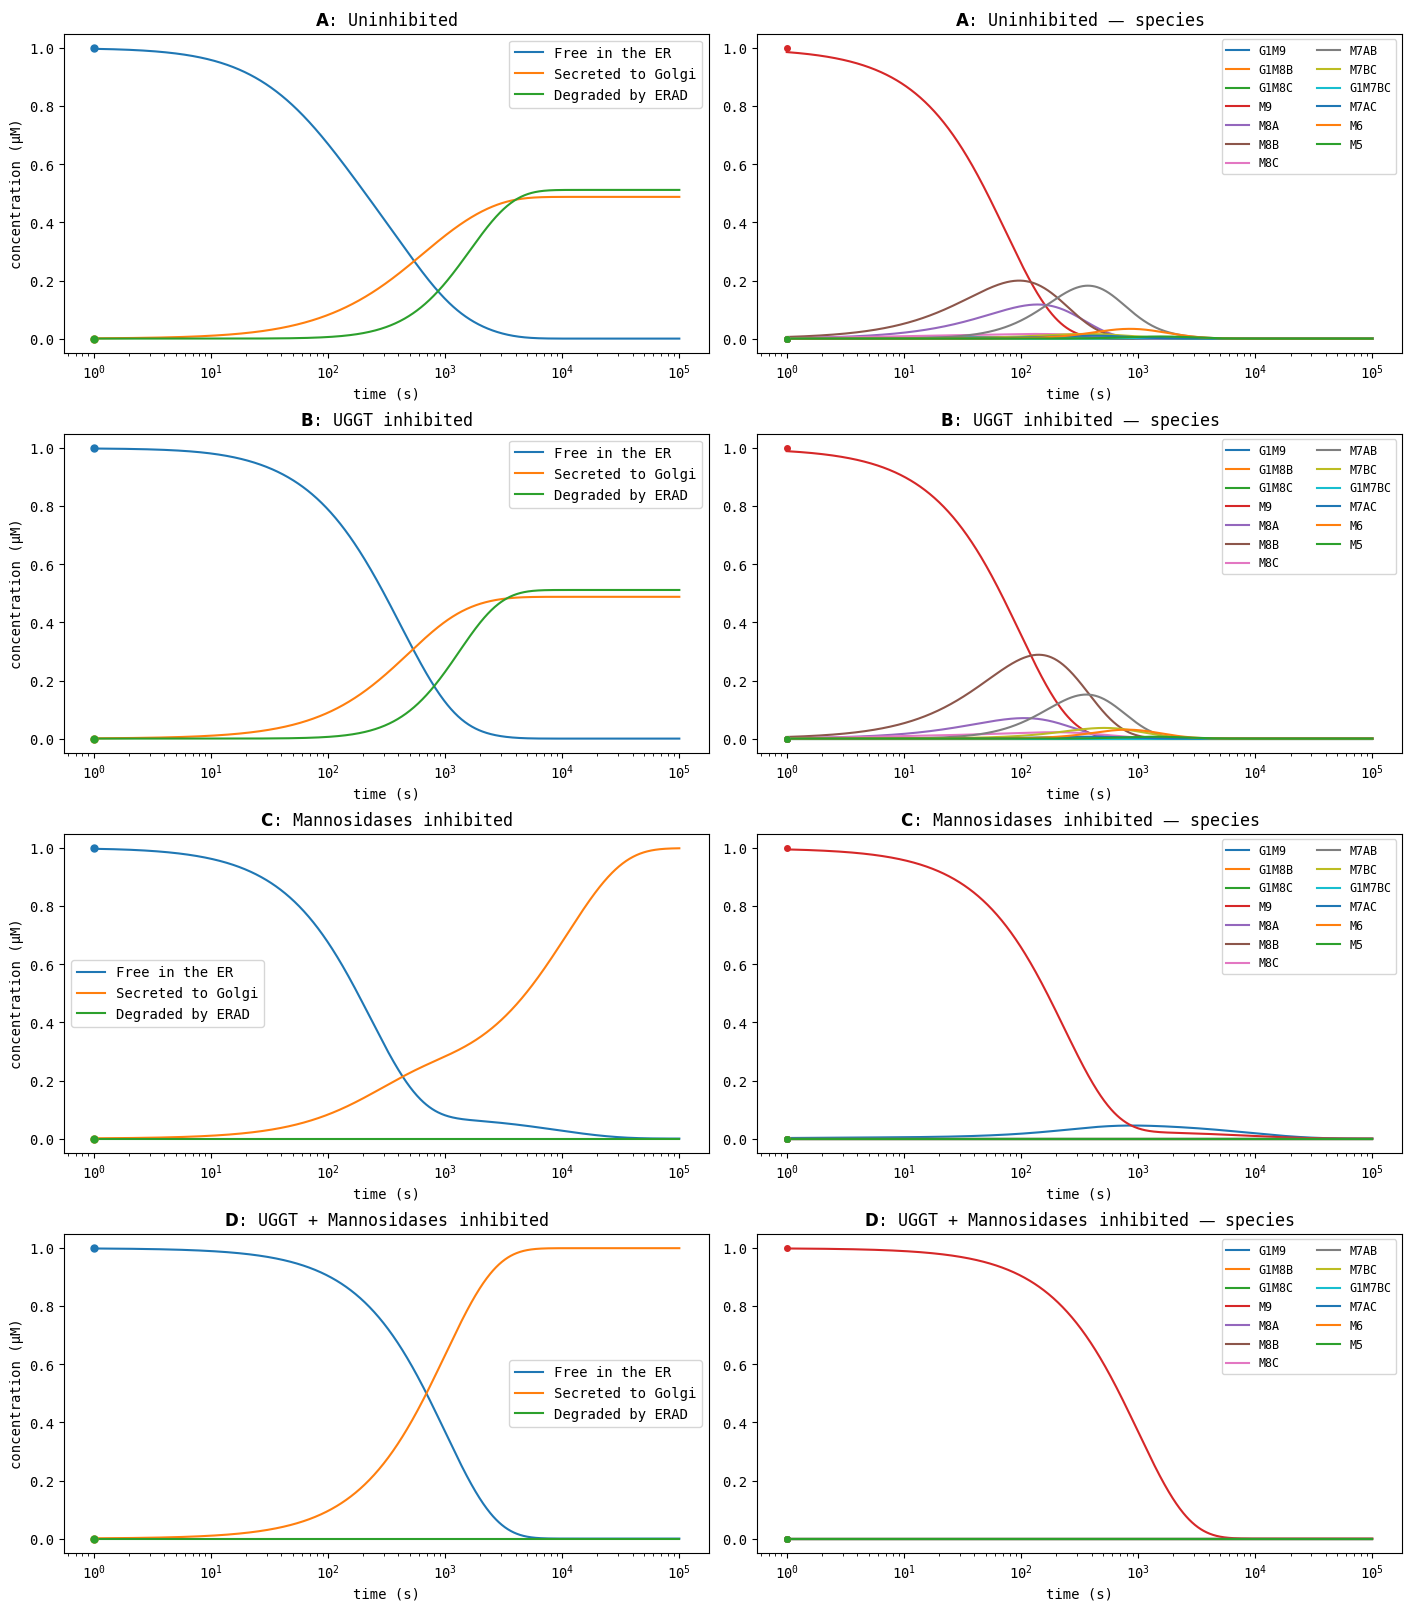

In [54]:
# ----------------------------
# Define the plotting funcitons (left: aggregate; right: separate species)
# ----------------------------
def plot_aggregated(ax, t, free_curve, sec_curve, deg_curve, title, t_marker=1e-0):
    line_free, = ax.plot(t, free_curve, label="Free in the ER")
    line_sec, = ax.plot(t, sec_curve, label="Secreted to Golgi")
    line_deg, = ax.plot(t, deg_curve, label="Degraded by ERAD")

    # show true t=0 initial values as small markers (using y0)
    init_free = sum(y0[name_to_index[s]] for s in free)
    init_sec = y0[name_to_index["SEC"]]
    init_degraded = 1.0 - (init_free + init_sec)  # CNX/OS9 complexes are initially zero
    ax.plot(t_marker, init_free, "o", color=line_free.get_color(), markersize=5, zorder=10)  # zorder=10 means "draw this on top of everything else"
    ax.plot(t_marker, init_sec, "o", color=line_sec.get_color(), markersize=5, zorder=10)
    ax.plot(t_marker, init_degraded, "o", color=line_deg.get_color(), markersize=5, zorder=10)

    ax.set_title(title)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("concentration (µM)")
    ax.set_xscale("log")
    ax.legend(loc="best")

def plot_species(ax, t, sol_y, species_list, title, t_marker=1e-0):
    for s in species_list:
        line, = ax.plot(t, sol_y[name_to_index[s], :], label=s)
        # plot t~0 marker for each species from y0
        init_val = float(y0[name_to_index[s]])
        ax.plot(t_marker, init_val, "o", color=line.get_color(), markersize=4, zorder=10)

    ax.set_title(title + " — species")
    ax.set_xlabel("time (s)")
    ax.set_xscale("log")
    ax.legend(loc="best", ncol=2, fontsize="small")

# ----------------------------
# Produce the figure
# ----------------------------
plt.rcParams['font.family'] = 'monospace'

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16), constrained_layout=True)

for row_idx, (title, t, free_sum, SEC, degraded, sol_y) in enumerate(results):
    ax_left = axes[row_idx, 0]
    ax_right = axes[row_idx, 1]

    # left: aggregated curves
    plot_aggregated(ax_left, t, free_sum, SEC, degraded, title)

    # right: species-level (plot 13 free glycoforms)
    plot_species(ax_right, t, sol_y, free, title)

plt.show()


#### **5b. Stackplots and heatmaps**

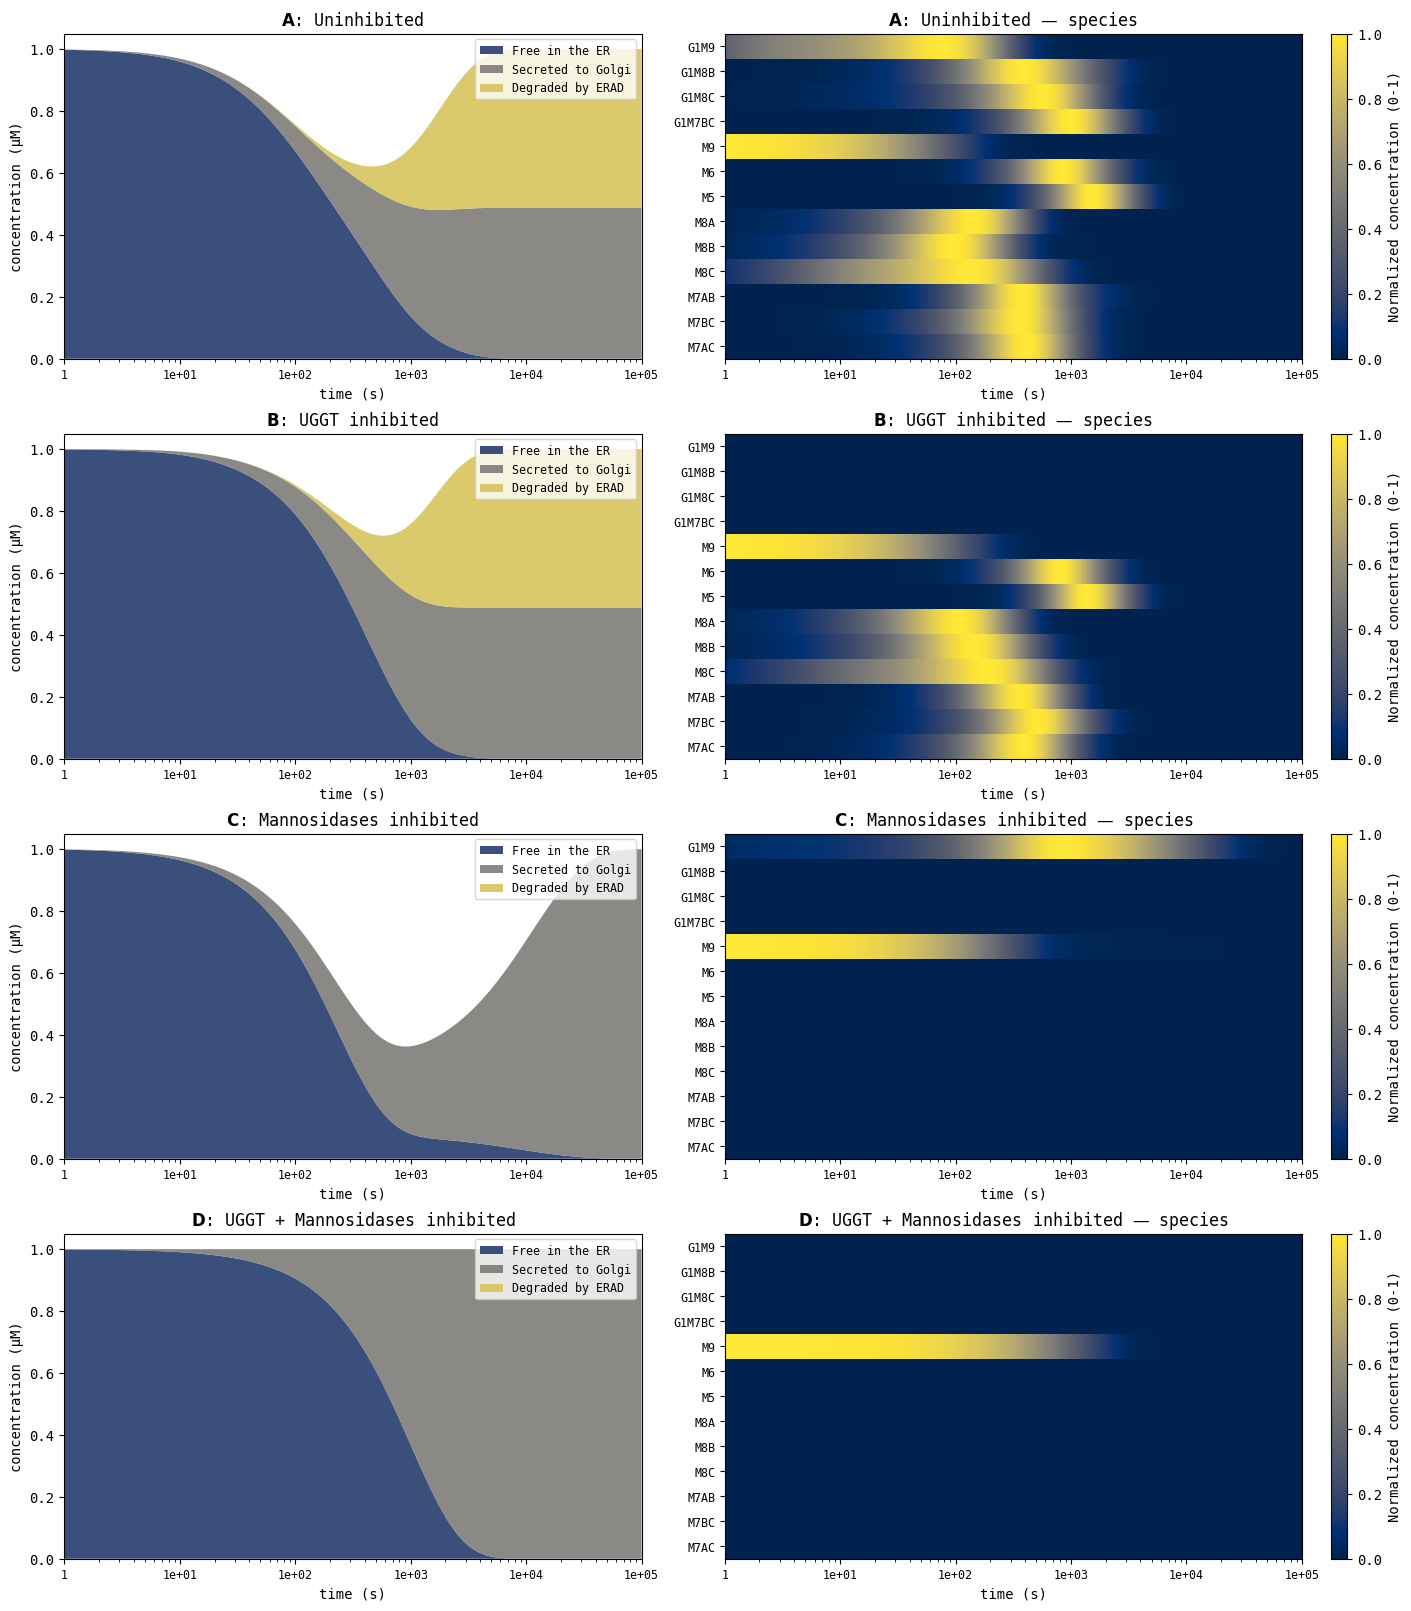

In [55]:
# ----------------------------
# Define the plotting funcitons (left: aggregated stackplots; right: species heatmaps)
# ----------------------------
def plot_aggregated_stack(ax, t, free_curve, sec_curve, deg_curve, title, t_marker=1e-0):
    """
    Draw stacked area (stackplot) for Free / Secreted / Degraded.
    Uses the order: Free (bottom), Secreted (middle), Degraded (top).
    """
    # prepare layers in same order used in legend
    layers = [free_curve, sec_curve, deg_curve]
    labels = ["Free in the ER", "Secreted to Golgi", "Degraded by ERAD"]

    # choose three colors sampled from the same colormap used for heatmaps (cividis)
    # sample positions 0.15 (bottom), 0.5 (middle), 0.85 (top) for good contrast
    colors = cmap([0.15, 0.5, 0.85])

    # stackplot using the cividis-derived colors
    ax.stackplot(t, *layers, labels=labels, colors=colors, edgecolor='none', alpha=0.9)
    ax.set_xscale("log")

    ax.set_title(title)
    ax.set_ylabel("concentration (µM)")
    ax.legend(loc="upper right", fontsize="small")


import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_species_heatmap(ax, t, sol_y, species_list, title, normalise_rows=True, cluster=False):
    """
    Draw a species x time heatmap for the provided species_list using sol_y data.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw the heatmap on.
    t : array-like
        Time points (used with a log x-axis).
    sol_y : 2D array-like
        Solution matrix where rows correspond to all species (indexable via name_to_index).
    species_list : list[str]
        Names of species to plot (subset of global name_to_index keys).
    title : str
        Title base for the subplot.
    normalise_rows : bool, optional
        If True, scale each species by its row-wise max (so values are in [0,1]).
    cluster : bool, optional
        If True, cluster rows (hierarchical clustering using 1-correlation). If False,
        use deterministic ordering:
          1) species with names starting with 'G1' (kept in original order),
          2) species starting with 'M' followed by a number, ordered by that number descending (M9, M8, ...),
    """
    # --- gather data: rows = species, cols = time
    # expects name_to_index to be available in calling scope
    indices = [name_to_index[s] for s in species_list]
    data = sol_y[indices, :].astype(float)  # shape (n_species, n_time)

    # normalization (row-wise)
    if normalise_rows:
        max_per_row = data.max(axis=1, keepdims=True)
        max_per_row[max_per_row == 0] = 1.0
        data_n = data / max_per_row
    else:
        data_n = data.copy()

    # determine ordering
    n_rows = data_n.shape[0]
    order = np.arange(n_rows, dtype=int)  # default original order

    if cluster:
        # cluster rows (species) to order similar temporal patterns together
        # use 1 - correlation as distance metric by clustering the normalized rows
        try:
            Z = linkage(data_n, method='average', metric='correlation')
            order = leaves_list(Z)
        except Exception:
            # fallback to original order if clustering fails
            order = np.arange(n_rows, dtype=int)
    else:
        # deterministic ordering:
        # group 0: names starting with 'G1' (preserve original species_list relative order)
        # group 1: names starting with 'M' followed by an integer -> order by integer descending
        g1_indices = []
        m_list = []  # list of tuples (numeric_value, original_index)
        m_pattern = re.compile(r'^M(\d+)\b')   # capture digits after leading 'M'
        for orig_idx, name in enumerate(species_list):
            if name.startswith('G1'):
                g1_indices.append(orig_idx)
            else:
                m_match = m_pattern.match(name)
                if m_match:
                    num = int(m_match.group(1))
                    m_list.append((num, orig_idx))

        # sort M species by numeric value descending (e.g., M9, M8, ...)
        if m_list:
            m_list_sorted = sorted(m_list, key=lambda x: -x[0])
            m_indices_sorted = [orig_idx for (_num, orig_idx) in m_list_sorted]
        else:
            m_indices_sorted = []

        # final ordering (indices into species_list)
        final_order_origidx = g1_indices + m_indices_sorted

        # if there are species in species_list not captured (unlikely), append them
        seen = set(final_order_origidx)
        for idx in range(len(species_list)):
            if idx not in seen:
                final_order_origidx.append(idx)

        # convert original indices into positions in data_n (they already align)
        order = np.array(final_order_origidx, dtype=int)

    # apply ordering
    data_ord = data_n[order, :]

    # prepare x coordinates in log space for pcolormesh
    logt = np.log10(t)
    dt = np.diff(logt)
    if dt.size > 0:
        left_edge = logt[0] - 0.5 * dt[0]
        right_edge = logt[-1] + 0.5 * dt[-1]
        logt_edges = np.concatenate(([left_edge], (logt[:-1] + logt[1:]) / 2.0, [right_edge]))
    else:
        # single point fallback
        logt_edges = np.array([logt[0] - 0.5, logt[0] + 0.5])

    # y edges for rows
    n_species = data_ord.shape[0]
    y_edges = np.arange(n_species + 1)

    # draw heatmap: use the precomputed cmap (assumed available)
    X_edges = 10 ** logt_edges
    mesh = ax.pcolormesh(X_edges, y_edges, data_ord, shading='auto', cmap=cmap, vmin=0.0, vmax=1.0)

    # set y tick labels to the ordered species names (centered)
    ax.set_yticks(np.arange(n_species) + 0.5)
    ordered_species = [species_list[i] for i in order]
    ax.set_yticklabels(ordered_species, fontsize="small")
    ax.invert_yaxis()  # put first row at top, common heatmap convention

    # log x-axis (tick labels will be set globally in the figure)
    ax.set_xscale('log')

    # title and colorbar
    ax.set_title(f"{title} — species")
    cb = plt.colorbar(mesh, ax=ax, pad=0.02)
    cb.set_label('Normalized concentration (0-1)' if normalise_rows else 'Concentration')


# ----------------------------
# Produce the figure
# ----------------------------
plt.rcParams['font.family'] = 'monospace'
cmap = mpl.colormaps.get_cmap("cividis")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16), constrained_layout=True)

# Determine a single consistent set of x-ticks for all axes (based on full t range)
# t is same length for each result (logspaced); compute global min/max
t_all_mins = [res[1][0] for res in results]
t_all_maxs = [res[1][-1] for res in results]
global_t_min = min(t_all_mins)
global_t_max = max(t_all_maxs)

possible_ticks = np.array([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
global_ticks = possible_ticks[(possible_ticks >= global_t_min) & (possible_ticks <= global_t_max)]
if len(global_ticks) < 4:
    # ensure at least 4 ticks by supplementing with logspace quantiles
    supplement = np.round(np.logspace(np.log10(global_t_min), np.log10(global_t_max), 4)).astype(int)
    global_ticks = np.unique(np.concatenate((global_ticks, supplement)))

# format tick labels (human-friendly)
global_ticklabels = [f"{x:.0g}" for x in global_ticks]

for row_idx, (title, t, free_sum, SEC, degraded, sol_y) in enumerate(results):
    ax_left = axes[row_idx, 0]
    ax_right = axes[row_idx, 1]

    # left: aggregated stackplot (Free, SEC, Degraded)
    plot_aggregated_stack(ax_left, t, free_sum, SEC, degraded, title, t_marker=global_ticks[0])

    # right: species-level heatmap (13 free glycoforms)
    plot_species_heatmap(ax_right, t, sol_y, free, title)

    # Set consistent x ticks and xlabels for both axes in this row
    for ax in (ax_left, ax_right):
        ax.set_xticks(global_ticks)
        ax.set_xticklabels(global_ticklabels, fontsize="small")
        ax.set_xlabel("time (s)")
        ax.set_xlim(global_t_min, global_t_max)

plt.show()


### **6. Computing carousel rides**

#### **6a. Analytical method**

In [ ]:
res_idx = 0
title, t, free_sum, SEC, degraded, sol_y = results[res_idx]

# Definition of time points and intervals between time points
times = t.copy()  # t_eval grid used in ODE solver

# Compute time-averaged binding rate rides_bar from ODE traces:
# rides(t) = k_on_CNX * sum_{S in cnx_bind} [S](t) * CNX_free(t)  (units: µM s^-1)
# Per-molecule rate (s^-1) is obtained dividing by the total glycoprotein pool (here assumed = pool_total_uM).
# Time-average over [t0, tN] is (1/T) * ∫ rides(t) dt

k_on_cnx = float(params["kon_CNX"])

# Precompute indices and traces
CNX_tot = params["CNX_tot"]
cnx_indices = [name_to_index[s] for s in cnx_bind]          # list of rows to sum
sum_S_trace = np.sum(sol_y[cnx_indices, :], axis=0)
CNX_free_trace = CNX_tot - sum_S_trace

vbind_trace = k_on_cnx * sum_S_trace * CNX_free_trace       # µM s^-1

# If your total glycoprotein pool is not 1 µM, set pool_total_uM accordingly.
pool_total_uM = 1.0
rides_t = vbind_trace / float(pool_total_uM)                # s^-1 (per unit-total-pool)

# Defensive checks before integration
times = np.asarray(times, dtype=float)
if times.ndim != 1 or rides_t.ndim != 1 or times.shape[0] != rides_t.shape[0]:
    raise ValueError("times and rides_t must be 1-D arrays of the same length")

if not np.all(np.diff(times) > 0):
    raise ValueError("times must be strictly increasing (no duplicates or decreasing values)")

duration = float(times[-1] - times[0])
if duration <= 0.0:
    raise ValueError("Non-positive time interval: cannot compute time-average")

integral_rides_t = np.trapezoid(rides_t, times)

rides_bar = integral_rides_t / duration

print(f"Analytical mean rides per second: {rides_bar:.6f} s^-1")

Analytical mean rides per second: 0.000140 s^-1


#### **6b. Monte Carlo method**

##### **Experimental conditions selection and definition of time points**

In [ ]:
# Select which experimental condition to analyze from the list of simulation results.
# Each element in results corresponds to one condition defined in conds, in order:
# A = Uninhibited, B = UGGT inhibited, C = Mannosidases inhibited, D = UGGT + Mannosidases inhibited.
# Here, res_idx = 0 selects the baseline (A) case.
res_idx = 0
title, t, free_sum, SEC, degraded, sol_y = results[res_idx]

# Definition of time points and intervals between time points
times = t.copy()                    # t_eval grid used in ODE solver
n_times = len(times)
dt = np.empty(n_times)
dt[:-1] = np.diff(times)
# dt[:-1] = times[1:] - times[:-1]  # the slicing version is equivalent but slightly more general.
dt[-1] = dt[-2]                     # last dt: reuse previous interval (no step after final time)

total_sim_time = times[-1] - times[0]   # use this as simulation duration (seconds)

##### **Building the graph and computing the hazards**

In [ ]:
# ----------------------------
# Preparing the values of CNX and OS9
# ----------------------------
# Precompute CNX_free(t) and OS9_free(t) as done in the ODE code:
CNX_bound_indices = [name_to_index[f"CNX_{s}"] for s in cnx_bind]
OS9_bound_indices = [name_to_index[f"OS9_{s}"] for s in os9_bind]
CNX_tot = params["CNX_tot"]
OS9_tot = params["OS9_tot"]

# Rows of the ODE solution that correspond to CNX–substrate and OS9–substrate complexes
CNX_bound_traces = sol_y[CNX_bound_indices, :]
OS9_bound_traces = sol_y[OS9_bound_indices, :]

# Arithmetic calculation of free lectins concentration for every time point
CNX_free_trace = CNX_tot - np.sum(CNX_bound_traces, axis=0)
OS9_free_trace  = OS9_tot  - np.sum(OS9_bound_traces, axis=0)

# ----------------------------
# Setting up the graph
# ----------------------------
# index of the initial state "M9"
start_state = name_to_index["M9"]

# indices of the sinks
SEC_state = name_to_index["SEC"]
# an internal absorbing state is used for degradation (not present in sol_y)
DEG_state = -1  # sentinel for "degraded/removed"

# Build transition list consistent with your ode_rhs:
# For each pair (source, target) we store a lambda function that given time index i returns the hazard at time i.
transitions = defaultdict(list)  # transitions[source] = list of (target, hazard_fn)

# ---- Free->CNX binding (time-dependent via CNX_free)
for s in cnx_bind:
    src = name_to_index[s]
    tgt = name_to_index[f"CNX_{s}"]
    kon = params["kon_CNX"]
    # hazard = kon * CNX_free(t)
    transitions[src].append((tgt, lambda i, kon=kon: kon * CNX_free_trace[i]))

# ---- Free->OS9 binding (time-dependent via OS9_free)
for s in os9_bind:
    src = name_to_index[s]
    tgt = name_to_index[f"OS9_{s}"]
    kon = params["kon_OS9"]
    transitions[src].append((tgt, lambda i, kon=kon: kon * OS9_free_trace[i]))

# ---- Secretion from any free glycoform -> SEC (constant hazard k_secretion)
ksec = params.get("k_secretion", 0.0)
if ksec > 0:
    for s in free:
        src = name_to_index[s]
        transitions[src].append((SEC_state, lambda i, ksec=ksec: ksec))

# ---- CNX_unbinding: CNX_s -> s (constant koff_CNX)
for s in cnx_bind:
    src = name_to_index[f"CNX_{s}"]
    tgt = name_to_index[s]
    koff = params["koff_CNX"]
    transitions[src].append((tgt, lambda i, koff=koff: koff))

# ---- OS9 unbind and ERAD sink: OS9_s -> s ; OS9_s -> DEG
for s in os9_bind:
    src = name_to_index[f"OS9_{s}"]
    tgt_back = name_to_index[s]
    kout = params["koff_OS9"]
    k_erad = params["k_ERAD_sink"]
    transitions[src].append((tgt_back, lambda i, kout=kout: kout))
    transitions[src].append((DEG_state,   lambda i, k_erad=k_erad: k_erad))

# ---- Enzymatic conversions encoded exactly as in ode_rhs
# UGGT (free -> glucosylated)
UGGT = params["UGGT"]
transitions[name_to_index["M9"]].append((name_to_index["G1M9"], lambda i, UGGT=UGGT: UGGT * params["k_UGGT_G1M9"]))
transitions[name_to_index["M8B"]].append((name_to_index["G1M8B"], lambda i, UGGT=UGGT: UGGT * params["k_UGGT_G1M8B"]))
transitions[name_to_index["M8C"]].append((name_to_index["G1M8C"], lambda i, UGGT=UGGT: UGGT * params["k_UGGT_G1M8C"]))
transitions[name_to_index["M7BC"]].append((name_to_index["G1M7BC"], lambda i, UGGT=UGGT: UGGT * params["k_UGGT_G1M7BC"]))

# GII (deglycosylation of free glucosylated forms)
GII = params["GII"]
transitions[name_to_index["G1M9"]].append((name_to_index["M9"], lambda i, GII=GII: GII * params["k_GII_M9"]))
transitions[name_to_index["G1M8B"]].append((name_to_index["M8B"], lambda i, GII=GII: GII * params["k_GII_M8B"]))
transitions[name_to_index["G1M8C"]].append((name_to_index["M8C"], lambda i, GII=GII: GII * params["k_GII_M8C"]))
transitions[name_to_index["G1M7BC"]].append((name_to_index["M7BC"], lambda i, GII=GII: GII * params["k_GII_M7BC"]))

# EREM (free glucosylated -> trimmed products) -- depends on params["EREM"]
EREM_pool = params.get("EREM", 0.0)
if EREM_pool > 0:
    transitions[name_to_index["G1M9"]].append((name_to_index["M8A"], lambda i, EREM_pool=EREM_pool: EREM_pool * params["k_EREM_M8A"]))
    transitions[name_to_index["G1M8B"]].append((name_to_index["M7AB"], lambda i, EREM_pool=EREM_pool: EREM_pool * params["k_EREM_M7AB"]))
    transitions[name_to_index["G1M8C"]].append((name_to_index["M7AC"], lambda i, EREM_pool=EREM_pool: EREM_pool * params["k_EREM_M7AC"]))
    transitions[name_to_index["G1M7BC"]].append((name_to_index["M6"], lambda i, EREM_pool=EREM_pool: EREM_pool * params["k_EREM_M6"]))

# ERManI and EDEM2 mappings (Branch B) -- pool constants: ERManI, EDEM2
ERManI_pool = params["ERManI"]
EDEM2_pool = params["EDEM2"]
# We add both pools as separate transitions (they just add hazards)
# ERManI effects:
transitions[name_to_index["M9"]].append((name_to_index["M8B"], lambda i, pool=ERManI_pool: pool * params["k_ERManI_M8B"]))
transitions[name_to_index["G1M9"]].append((name_to_index["G1M8B"], lambda i, pool=ERManI_pool: pool * params["k_ERManI_G1M8B"]))
transitions[name_to_index["M8C"]].append((name_to_index["M7BC"], lambda i, pool=ERManI_pool: pool * params["k_ERManI_M7BC"]))
transitions[name_to_index["G1M8C"]].append((name_to_index["G1M7BC"], lambda i, pool=ERManI_pool: pool * params["k_ERManI_G1M7BC"]))
transitions[name_to_index["M8A"]].append((name_to_index["M7AB"], lambda i, pool=ERManI_pool: pool * params["k_ERManI_M7AB"]))
transitions[name_to_index["M7AC"]].append((name_to_index["M6"], lambda i, pool=ERManI_pool: pool * params["k_ERManI_M6"]))

# EDEM2: (same mapping names as ERManI but with k_EDEM2_ keys)
transitions[name_to_index["M9"]].append((name_to_index["M8B"], lambda i, pool=EDEM2_pool: pool * params["k_EDEM2_M8B"]))
transitions[name_to_index["G1M9"]].append((name_to_index["G1M8B"], lambda i, pool=EDEM2_pool: pool * params["k_EDEM2_G1M8B"]))
transitions[name_to_index["M8C"]].append((name_to_index["M7BC"], lambda i, pool=EDEM2_pool: pool * params["k_EDEM2_M7BC"]))
transitions[name_to_index["G1M8C"]].append((name_to_index["G1M7BC"], lambda i, pool=EDEM2_pool: pool * params["k_EDEM2_G1M7BC"]))
transitions[name_to_index["M8A"]].append((name_to_index["M7AB"], lambda i, pool=EDEM2_pool: pool * params["k_EDEM2_M7AB"]))
transitions[name_to_index["M7AC"]].append((name_to_index["M6"], lambda i, pool=EDEM2_pool: pool * params["k_EDEM2_M6"]))

# EDEM1 and EDEM3 mappings (Branch A & C)
EDEM1_pool = params["EDEM1"]
EDEM3_pool = params["EDEM3"]
# EDEM1 mapping (same keys used in ode_rhs)
transitions[name_to_index["M9"]].append((name_to_index["M8A"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M8A"]))
transitions[name_to_index["M8B"]].append((name_to_index["M7AB"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M7AB"]))
transitions[name_to_index["M7BC"]].append((name_to_index["M6"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M6_from_M7BC"]))
transitions[name_to_index["M8C"]].append((name_to_index["M7AC"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M7AC"]))
transitions[name_to_index["M6"]].append((name_to_index["M5"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M5"]))
transitions[name_to_index["M9"]].append((name_to_index["M8C"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M8C"]))
transitions[name_to_index["M8B"]].append((name_to_index["M7BC"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M7BC"]))
transitions[name_to_index["M7AB"]].append((name_to_index["M6"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M6_from_M7AB"]))
transitions[name_to_index["M8A"]].append((name_to_index["M7AC"], lambda i, pool=EDEM1_pool: pool * params["k_EDEM1_M7AC_from_M8A"]))

# EDEM3 mapping (same structure)
transitions[name_to_index["M9"]].append((name_to_index["M8A"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M8A"]))
transitions[name_to_index["M8B"]].append((name_to_index["M7AB"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M7AB"]))
transitions[name_to_index["M7BC"]].append((name_to_index["M6"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M6_from_M7BC"]))
transitions[name_to_index["M8C"]].append((name_to_index["M7AC"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M7AC"]))
transitions[name_to_index["M6"]].append((name_to_index["M5"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M5"]))
transitions[name_to_index["M9"]].append((name_to_index["M8C"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M8C"]))
transitions[name_to_index["M8B"]].append((name_to_index["M7BC"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M7BC"]))
transitions[name_to_index["M7AB"]].append((name_to_index["M6"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M6_from_M7AB"]))
transitions[name_to_index["M8A"]].append((name_to_index["M7AC"], lambda i, pool=EDEM3_pool: pool * params["k_EDEM3_M7AC_from_M8A"]))

##### **Visualizing the graph at time zero**

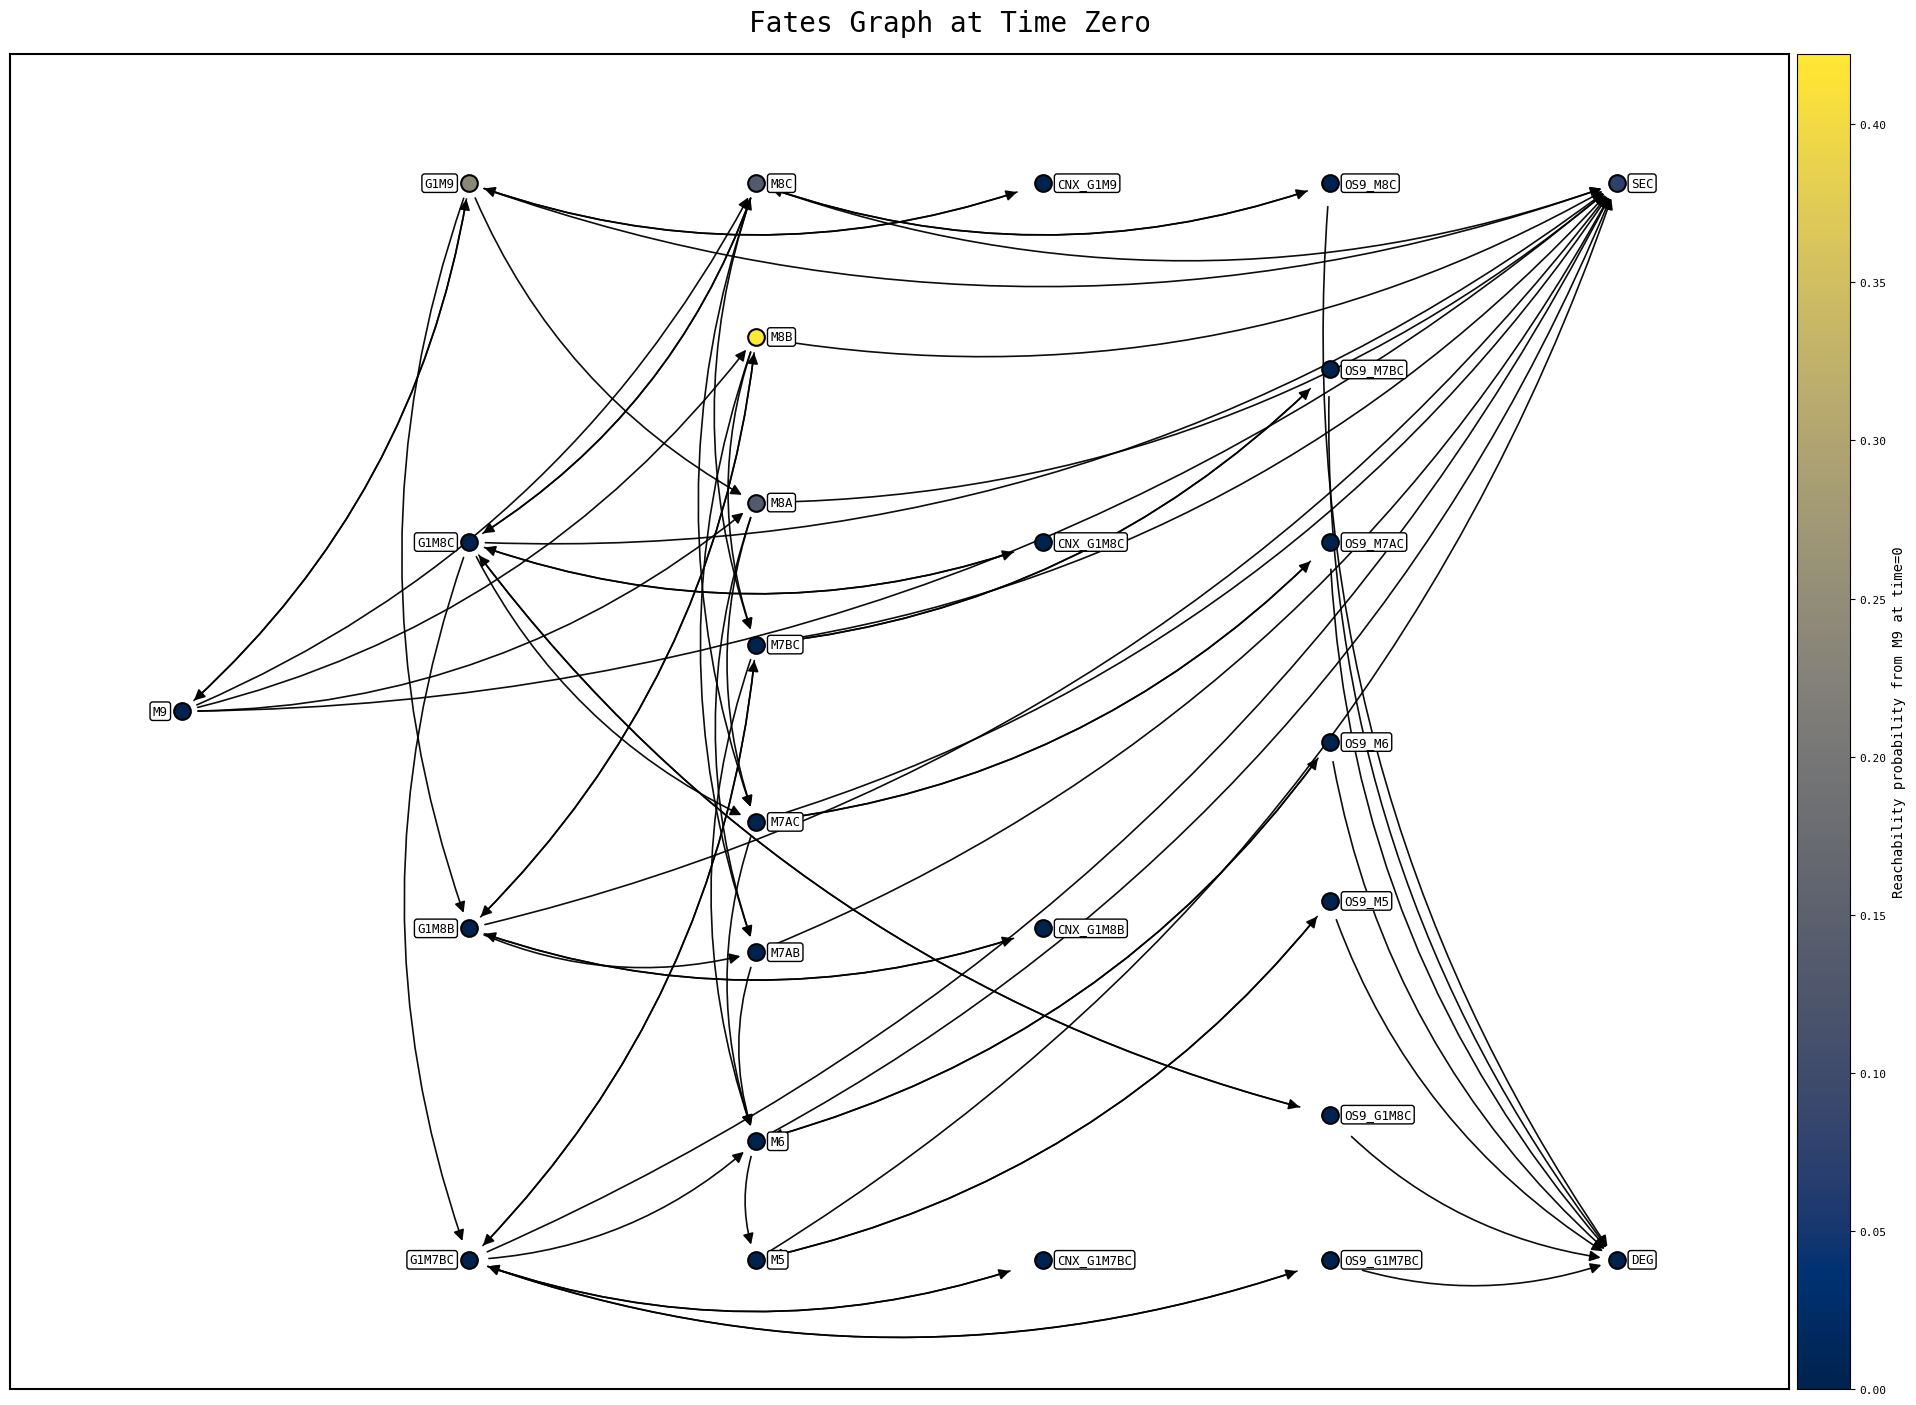

In [ ]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import rcParams
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict

# Monospace typography for everything (requirement 6)
rcParams['font.family'] = 'monospace'


# -----------------------------
# Build raw edge list at t = 0
# -----------------------------
def compute_all_edges_and_hazards_at_t0(params, name_to_index, y0, free, cnx_bind, os9_bind):
    g = lambda s: float(y0[name_to_index[s]]) if s in name_to_index else 0.0
    edges = []

    CNX_free = params["CNX_tot"] - sum(g(f"CNX_{s}") for s in cnx_bind)
    for s in cnx_bind:
        bind = params["kon_CNX"] * g(s) * CNX_free
        unbd = params["koff_CNX"] * g(f"CNX_{s}")
        edges.append((s, f"CNX_{s}", float(bind), "kon_CNX"))
        edges.append((f"CNX_{s}", s, float(unbd), "koff_CNX"))

    OS9_free = params["OS9_tot"] - sum(g(f"OS9_{s}") for s in os9_bind)
    for s in os9_bind:
        bind = params["kon_OS9"] * g(s) * OS9_free
        unbd = params["koff_OS9"] * g(f"OS9_{s}")
        erad = params["k_ERAD_sink"] * g(f"OS9_{s}")
        edges.append((s, f"OS9_{s}", float(bind), "kon_OS9"))
        edges.append((f"OS9_{s}", s, float(unbd), "koff_OS9"))
        edges.append((f"OS9_{s}", "DEG", float(erad), "k_ERAD_sink"))

    ksec = params.get("k_secretion", 0.0)
    for s in free:
        v_sec = ksec * g(s)
        edges.append((s, "SEC", float(v_sec), "k_secretion"))

    UGGT = params["UGGT"]; GII = params["GII"]
    ERManI = params["ERManI"]; EDEM1 = params["EDEM1"]
    EDEM2 = params["EDEM2"]; EDEM3 = params["EDEM3"]
    EREM = params.get("EREM", 0.0)

    def bi(pool, k, substrate):
        return float(pool * k * substrate)

    # UGGT
    edges.append(("M9", "G1M9", bi(UGGT, params["k_UGGT_G1M9"], g("M9")), "UGGT:k_UGGT_G1M9"))
    edges.append(("M8B", "G1M8B", bi(UGGT, params["k_UGGT_G1M8B"], g("M8B")), "UGGT:k_UGGT_G1M8B"))
    edges.append(("M8C", "G1M8C", bi(UGGT, params["k_UGGT_G1M8C"], g("M8C")), "UGGT:k_UGGT_G1M8C"))
    edges.append(("M7BC", "G1M7BC", bi(UGGT, params["k_UGGT_G1M7BC"], g("M7BC")), "UGGT:k_UGGT_G1M7BC"))

    # GII
    edges.append(("G1M9", "M9", bi(GII, params["k_GII_M9"], g("G1M9")), "GII:k_GII_M9"))
    edges.append(("G1M8B", "M8B", bi(GII, params["k_GII_M8B"], g("G1M8B")), "GII:k_GII_M8B"))
    edges.append(("G1M8C", "M8C", bi(GII, params["k_GII_M8C"], g("G1M8C")), "GII:k_GII_M8C"))
    edges.append(("G1M7BC", "M7BC", bi(GII, params["k_GII_M7BC"], g("G1M7BC")), "GII:k_GII_M7BC"))

    # EREM
    edges.append(("G1M9", "M8A", bi(EREM, params.get("k_EREM_M8A", 0.0), g("G1M9")), "EREM:k_EREM_M8A"))
    edges.append(("G1M8B", "M7AB", bi(EREM, params.get("k_EREM_M7AB", 0.0), g("G1M8B")), "EREM:k_EREM_M7AB"))
    edges.append(("G1M8C", "M7AC", bi(EREM, params.get("k_EREM_M7AC", 0.0), g("G1M8C")), "EREM:k_EREM_M7AC"))
    edges.append(("G1M7BC", "M6", bi(EREM, params.get("k_EREM_M6", 0.0), g("G1M7BC")), "EREM:k_EREM_M6"))

    # ERManI, EDEM2 (these may both add transitions M9->M8B, G1M9->G1M8B, ...)
    for pool, pref, tag in [(ERManI, "k_ERManI_", "ERManI"), (EDEM2, "k_EDEM2_", "EDEM2")]:
        edges.append(("M9", "M8B", bi(pool, params.get(pref + "M8B", 0.0), g("M9")), f"{tag}:{pref}M8B"))
        edges.append(("G1M9", "G1M8B", bi(pool, params.get(pref + "G1M8B", 0.0), g("G1M9")), f"{tag}:{pref}G1M8B"))
        edges.append(("M8C", "M7BC", bi(pool, params.get(pref + "M7BC", 0.0), g("M8C")), f"{tag}:{pref}M7BC"))
        edges.append(("G1M8C", "G1M7BC", bi(pool, params.get(pref + "G1M7BC", 0.0), g("G1M8C")), f"{tag}:{pref}G1M7BC"))
        edges.append(("M8A", "M7AB", bi(pool, params.get(pref + "M7AB", 0.0), g("M8A")), f"{tag}:{pref}M7AB"))
        edges.append(("M7AC", "M6", bi(pool, params.get(pref + "M6", 0.0), g("M7AC")), f"{tag}:{pref}M6"))

    # EDEM1, EDEM3
    for pool, pref, tag in [(EDEM1, "k_EDEM1_", "EDEM1"), (EDEM3, "k_EDEM3_", "EDEM3")]:
        edges.append(("M9", "M8A", bi(pool, params.get(pref + "M8A", 0.0), g("M9")), f"{tag}:{pref}M8A"))
        edges.append(("M8B", "M7AB", bi(pool, params.get(pref + "M7AB", 0.0), g("M8B")), f"{tag}:{pref}M7AB"))
        edges.append(("M7BC", "M6", bi(pool, params.get(pref + "M6_from_M7BC", 0.0), g("M7BC")), f"{tag}:{pref}M6_from_M7BC"))
        edges.append(("M8C", "M7AC", bi(pool, params.get(pref + "M7AC", 0.0), g("M8C")), f"{tag}:{pref}M7AC"))
        edges.append(("M6", "M5", bi(pool, params.get(pref + "M5", 0.0), g("M6")), f"{tag}:{pref}M5"))
        edges.append(("M9", "M8C", bi(pool, params.get(pref + "M8C", 0.0), g("M9")), f"{tag}:{pref}M8C"))
        edges.append(("M8B", "M7BC", bi(pool, params.get(pref + "M7BC", 0.0), g("M8B")), f"{tag}:{pref}M7BC"))
        edges.append(("M7AB", "M6", bi(pool, params.get(pref + "M6_from_M7AB", 0.0), g("M7AB")), f"{tag}:{pref}M6_from_M7AB"))
        edges.append(("M8A", "M7AC", bi(pool, params.get(pref + "M7AC_from_M8A", 0.0), g("M8A")), f"{tag}:{pref}M7AC_from_M8A"))

    return edges


# ---------------------------------------------------------
# Build DiGraph and aggregate channels (kept)
# ---------------------------------------------------------
def build_graph_from_edges(edges):
    G = nx.DiGraph()
    for src, tgt, rate, label in edges:
        if src not in G:
            G.add_node(src)
        if tgt not in G:
            G.add_node(tgt)
        if G.has_edge(src, tgt):
            G.edges[src, tgt].setdefault('channels', []).append({'rate': float(rate), 'label': label})
        else:
            G.add_edge(src, tgt, channels=[{'rate': float(rate), 'label': label}])
    return G


# ---------------------------------------------------------
# Aggregate per-directed-pair into a single (u->v) channel
# (KEY CHANGE: sum rates from multiple enzymes so we draw only one edge)
# ---------------------------------------------------------
def collapse_channels_to_single_per_pair(G):
    """
    Return a new DiGraph G2 where each directed pair (u->v) has exactly one
    channel with:
      - 'rate' = sum of the original channels' rates
      - 'labels' = semicolon-joined labels for provenance (optional)
    This prevents multiple parallel arcs for multi-enzyme contributions.
    """
    G2 = nx.DiGraph()
    # copy nodes
    for n in G.nodes():
        G2.add_node(n)
    # aggregate channels
    for u, v, d in G.edges(data=True):
        sum_rate = 0.0
        labels = []
        for ch in d.get('channels', []):
            sum_rate += float(ch.get('rate', 0.0))
            labels.append(str(ch.get('label', '')))
        # add single aggregated channel as list with one dict (keeps structure similar)
        G2.add_edge(u, v, channels=[{'rate': sum_rate, 'label': ";".join(labels)}])
    return G2


# ---------------------------------------------------------
# Compute one-step reachability probabilities from start node
# Uses aggregated rates (so node colors reflect the single-edge view)
# ---------------------------------------------------------
def compute_one_step_reachability_from_start(G, start_node):
    rates_by_target = defaultdict(float)
    for _, v, d in G.out_edges(start_node, data=True):
        # each edge has channels list, but after collapse there will be just one aggregated channel
        for ch in d.get('channels', []):
            rates_by_target[v] += float(ch['rate'])
    total = sum(rates_by_target.values())
    probs = {n: (rates_by_target.get(n, 0.0) / total if total > 0 else 0.0) for n in G.nodes()}
    return probs


# ---------------------------------------------------------
# Plotting function: uses collapsed graph so one edge per directed pair
# ---------------------------------------------------------
def plot_reaction_graph_at_t0(params, name_to_index, y0, free, cnx_bind, os9_bind, start_state_name="M9"):
    # build raw graph and then collapse parallel channels to a single aggregated channel
    edges = compute_all_edges_and_hazards_at_t0(params, name_to_index, y0, free, cnx_bind, os9_bind)
    G_raw = build_graph_from_edges(edges)

    # ensure sentinel nodes exist
    if "SEC" not in G_raw:
        G_raw.add_node("SEC")
    if "DEG" not in G_raw:
        G_raw.add_node("DEG")

    # collapse channels so we draw only one arrow per directed pair (summing rates)
    G = collapse_channels_to_single_per_pair(G_raw)

    # layering (same approach as before)
    layers = {}
    for n in G.nodes():
        if n == "M9":
            layers[n] = 0
    for n in sorted(G.nodes()):
        if n.startswith("G1") and n not in layers:
            layers[n] = 1
    for n in sorted(G.nodes()):
        if n in free and n != "M9" and n not in layers:
            layers[n] = 2
    for n in sorted(G.nodes()):
        if n.startswith("CNX_"):
            layers[n] = 3
    for n in sorted(G.nodes()):
        if n.startswith("OS9_"):
            layers[n] = 4
    for n in sorted(G.nodes()):
        if n in ("SEC", "DEG"):
            layers[n] = 5
    for n in G.nodes():
        if n not in layers:
            layers[n] = 3

    layer_to_nodes = {}
    for n, l in layers.items():
        layer_to_nodes.setdefault(l, []).append(n)

    # positions: align horizontally within layers, small jitter to avoid perfect overlap
    pos = {}
    x_gap = 3.6
    intra_x_jitter = 0.0
    intra_y_jitter = 0.015
    for l in sorted(layer_to_nodes.keys()):
        nodes = sorted(layer_to_nodes[l])
        n_nodes = len(nodes)
        ys = np.linspace(0.1, 0.9, n_nodes) if n_nodes > 1 else [0.5]
        offsets = (np.arange(n_nodes) - (n_nodes - 1) / 2.0) * intra_x_jitter if n_nodes > 1 else np.array([0.0])
        x_base = l * x_gap
        for i, n in enumerate(nodes):
            y_micro = ys[i] + ((-1) ** i) * intra_y_jitter * (1.0 - (i / max(1, n_nodes - 1)))
            pos[n] = (float(x_base + offsets[i]), float(y_micro))

    # node coloring: compute reachability from start using aggregated rates
    node_probs = compute_one_step_reachability_from_start(G, start_state_name)
    pvals = np.array(list(node_probs.values()))
    vmax = max(pvals.max(), 1e-9)
    vmin = 0.0
    cmap = mpl.colormaps.get_cmap('cividis')
    norm = Normalize(vmin=vmin, vmax=vmax)

    # plotting setup
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.set_aspect('auto')
    ax.set_axisbelow(True)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    # draw nodes: fill by probability, black border
    circle_radius_pts = 12.0
    node_texts = {}
    for n, (x, y) in pos.items():
        if layers.get(n, 3) in (0, 1):
            label_x_offset = -0.18
            ha = 'right'
        else:
            label_x_offset = 0.18
            ha = 'left'

        prob_val = node_probs.get(n, 0.0)
        facecolor = cmap(norm(prob_val))

        ax.scatter(x, y, s=(circle_radius_pts ** 2), color=facecolor, edgecolor='black',
                   linewidth=1.5, zorder=50)

        # label: black text on white rounded rect with black border (requirement 3)
        t = ax.text(x + label_x_offset, y, n,
                    ha=ha, va='center',
                    fontsize=9,
                    fontfamily='monospace',
                    color='black',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.22'),
                    zorder=200,
                    clip_on=False)
        node_texts[n] = t

    # renderer acquisition robustly (fixes backend differences)
    fig.canvas.draw()
    try:
        renderer = fig.canvas.get_renderer()
    except Exception:
        renderer = getattr(fig.canvas, "renderer", None)

    # compute shrink_by_node so arrowheads touch node borders (improves arrow alignment)
    shrink_by_node = {}
    for n, text in node_texts.items():
        if renderer is not None:
            bb = text.get_window_extent(renderer=renderer)
            w_px, h_px = bb.width, bb.height
            half_diag_px = 0.5 * np.hypot(w_px, h_px)
            half_diag_pts = half_diag_px * 72.0 / fig.dpi
            margin_pts = 2.0
            shrink_pts = max(circle_radius_pts, half_diag_pts - margin_pts)
        else:
            shrink_pts = circle_radius_pts
        shrink_by_node[n] = float(shrink_pts)

    # --- DRAW EDGES: now one aggregated arrow per directed pair (no duplicate arrows) ---
    base_rad_offset = 0.18
    micro_offset = 0.04
    arc_counter = defaultdict(int)

    for u, v, d in G.edges(data=True):
        # after collapse there is a single aggregated channel in d['channels']
        agg_ch = d.get('channels', [{}])[0]
        rate = float(agg_ch.get('rate', 0.0))
        label_combined = agg_ch.get('label', '')

        idx_arc = arc_counter[(u, v)]
        arc_counter[(u, v)] += 1

        # choose curvature sign to separate reciprocal arrows nicely
        sign = 1.0 if layers.get(u, 3) <= layers.get(v, 3) else -1.0
        rad = sign * (base_rad_offset + idx_arc * micro_offset)

        shrinkA = max(1.0, shrink_by_node.get(u, circle_radius_pts) - 0.5)
        shrinkB = max(1.0, shrink_by_node.get(v, circle_radius_pts) - 0.5)

        posA = tuple(pos[u])
        posB = tuple(pos[v])

        # All edges must remain black (requirement 2). Use a single arrow per directed pair.
        arrow = FancyArrowPatch(
            posA=posA, posB=posB,
            connectionstyle=f"arc3,rad={rad}",
            arrowstyle='-|>',
            mutation_scale=16,
            lw=1.2,
            color='black',
            shrinkA=shrinkA,
            shrinkB=shrinkB,
            zorder=40,
            alpha=0.95
        )
        ax.add_patch(arrow)

        # (Optional) If you want a tiny label on the edge showing the summed rate,
        # uncomment the lines below. It's placed mid-arc; adjust offset if needed.
        # mx = 0.5 * (posA[0] + posB[0])
        # my = 0.5 * (posA[1] + posB[1])
        # ax.text(mx, my, f"{rate:.2e}", fontsize=7, fontfamily='monospace',
        #         ha='center', va='center', backgroundcolor='white', zorder=210)

    # colorbar for node probabilities (we colored nodes not edges)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.08)
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label("Reachability probability from M9 at time=0", fontfamily='monospace')
    cb.ax.tick_params(labelsize=8)

    # adjust axes limits and finalize
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    x_range = np.ptp(xs) if np.ptp(xs) > 0 else 1.0
    y_range = np.ptp(ys) if np.ptp(ys) > 0 else 1.0
    x_margin = max(0.8, 0.12 * x_range)
    y_margin = max(0.06, 0.12 * y_range)
    ax.set_xlim(xs.min() - x_margin, xs.max() + x_margin)
    ax.set_ylim(ys.min() - y_margin, ys.max() + y_margin)
    ax.set_xticks([]); ax.set_yticks([])

    fig.suptitle("Fates Graph at Time Zero", fontsize=20, fontfamily='monospace', x=0.5, y=0.95, ha='center')
    fig.subplots_adjust(left=0.03, right=0.95, top=0.92, bottom=0.03)

    fig.canvas.draw()
    plt.show()

plot_reaction_graph_at_t0(params, name_to_index, y0, free, cnx_bind, os9_bind, start_state_name="M9")

# -----------------------------
# Usage (same as before):
# -----------------------------
# provide params, name_to_index, y0, free, cnx_bind, os9_bind, then:
# plot_reaction_graph_at_t0(params, name_to_index, y0, free, cnx_bind, os9_bind, start_state_name="M9")
#
# -----------------------------
# Explanation (brief, data-driven):
# - Why you previously saw two arrows G1M9 -> G1M8B:
#     Both ERManI and EDEM2 (for instance) may add transitions with the same
#     source and target. Earlier plotting drew every channel individually,
#     producing parallel arcs. This script **sums** those channel rates and
#     draws a single arrow per directed pair, matching the interpretation
#     "one transition between nodes whose hazard is the sum of catalytic contributions".
# - If you prefer to keep separate visual arcs for each enzyme (provenance),
#     we can instead annotate the single arrow with a composite label or draw
#     thinner, color-differentiated parallel arcs — but you asked for a single edge,
#     so we've summed rates and collapsed labels.
#
# If you want the aggregated edge to keep an explicit label like "ERManI+EDEM2"
# or to show the numeric summed rate on the figure, I can add that as small
# edge text (commented out near where arrows are drawn).


##### **Defining and running the MC simulation**

In [ ]:
def simulate_ctmc_montecarlo(Ntraj=2000, rng_seed=None):
    rng = np.random.default_rng(rng_seed)
    rides_counts = np.zeros(Ntraj, dtype=int)
    lifetimes = np.zeros(Ntraj, dtype=float)  # time until SEC or DEG

    for tr in range(Ntraj):
        state = start_state
        time_elapsed = 0.0
        rides = 0

        for i in range(n_times):
            if state == SEC_state or state == DEG_state:
                # already absorbed; nothing changes in remaining time
                time_elapsed = total_sim_time
                break
            this_dt = dt[i]

            # gather outgoing transitions for current state
            outs = transitions.get(state, [])

            # compute hazards for this time index
            hazards = []
            targets = []
            for (tgt, hazard_fn) in outs:
                lam = hazard_fn(i)  # hazard at time index i
                if lam < 0:
                    lam = 0.0
                # Hazards (lam) should always be ≥ 0 by definition, but small negative values can appear due to:
                # 1) Numerical round-off or solver overshoot in ODE solutions (e.g., -1e-15 instead of 0)
                # 2) Interpolation or indexing errors when reading time-dependent traces
                # 3) Mis-specified or negative parameters captured by lambda closures
                # To avoid producing invalid probabilities (p_any < 0), clamp such small negatives to 0.0
                hazards.append(lam)
                targets.append(tgt)
            if len(hazards) == 0:
                # no outgoing transitions (shouldn't happen except for SEC/DEG)
                time_elapsed += this_dt
                continue
            lam_sum = sum(hazards)
            if lam_sum <= 0:
                # no propensity: nothing happens this dt
                time_elapsed += this_dt
                continue

            # Compute the probability that any event happens during dt:
            # For an exponential waiting process with total hazard λ_sum,
            # the probability that at least one event occurs in time Δt is:
            #
            #   p_any = 1 - exp(-λ_sum * Δt)
            #
            # Then draw a uniform random number U ~ Uniform(0,1):
            #
            #   if U < p_any → an event occurs (success)
            #   else         → no event this time step (failure)
            #
            # This is equivalent to a Bernoulli trial with success probability p_any.
            p_any = 1.0 - math.exp(-lam_sum * this_dt)
            if rng.random() < p_any:
                # At least one event occurs. Now we must choose which one
                # according to their relative hazards.
                #
                # weights = individual hazard_i / total hazard_sum
                # These weights form a discrete probability distribution.
                #
                # Example: hazards = [2, 1, 7] → weights = [0.2, 0.1, 0.7]
                #
                # The cumulative sum defines contiguous intervals on [0,1):
                #
                #   |----0.2----|--0.1--|--------------------0.7--------------------|
                #   0           0.2     0.3                                    1.0
                #
                # A new random number r ∈ [0,1) picks a point in this line.
                # Whichever interval r falls into determines which event occurs.
                weights = np.array(hazards) / lam_sum
                r = rng.random()
                c = 0.0
                chosen_idx = 0
                for k, w in enumerate(weights):
                    c += w
                    if r < c:
                        chosen_idx = k
                        break
                chosen_target = targets[chosen_idx]

                # Handle the event that just occurred (transition: state → chosen_target)

                # We want to count how many times the glycoprotein binds CNX.
                # That means: whenever we move from a "free" glycoform to its corresponding CNX-bound form,
                # we increment the "rides" counter.

                # Identify the target state's name for easy inspection
                if isinstance(chosen_target, int) and chosen_target >= 0:
                    tgt_name = full_ER[chosen_target]     # normal state name
                elif chosen_target == DEG_state:
                    tgt_name = "DEG"                      # ERAD sink
                else:
                    tgt_name = str(chosen_target)         # fallback (shouldn't happen, and maybe it should be designed better)

                # If the current state is one of the CNX-bindable "free" species
                # AND the chosen target state name begins with "CNX_",
                # then this transition represents a free→CNX binding event.
                # Each such event is counted as one "ride".
                if (state in [name_to_index[s] for s in cnx_bind]) and tgt_name.startswith("CNX_"):
                    rides += 1

                # Update state
                state = chosen_target
                # if we hit DEG, lifetime ends
                if state == DEG_state:
                    time_elapsed += this_dt
                    break
                if state == SEC_state:
                    time_elapsed += this_dt
                    break
            # advance time
            time_elapsed += this_dt
        # record
        rides_counts[tr] = rides
        lifetimes[tr] = time_elapsed

    mean_rides = rides_counts.mean()
    std_rides = rides_counts.std(ddof=1)
    mean_rides_per_s = np.mean(rides_counts / total_sim_time)
    std_rides_per_s = np.std(rides_counts / total_sim_time, ddof=1)

    return {
        "Ntraj": Ntraj,
        "rides_counts": rides_counts,
        "mean_rides": mean_rides,
        "std_rides": std_rides,
        "mean_rides_per_s": mean_rides_per_s,
        "std_rides_per_s": std_rides_per_s,
        "lifetimes": lifetimes
    }

# Run the simulation
res_mc = simulate_ctmc_montecarlo(Ntraj=2000, rng_seed=42)

# Print results
print(f"Condition {title}")
print(f"Simulation duration: {times[0]:.3g} s -> {times[-1]:.3g} s")
print(f"Monte Carlo (N={res_mc['Ntraj']}) mean rides per molecule: {res_mc['mean_rides']:.3f} ± {res_mc['std_rides']:.3f}")
print(f"Monte Carlo (N={res_mc['Ntraj']}) mean rides per second: {res_mc['mean_rides_per_s']:.6f} ± {res_mc['std_rides_per_s']:.6f} (s^-1)")

Condition $\bf{A}$: Uninhibited
Simulation duration: 1 s -> 1e+05 s
Monte Carlo (N=2000) mean rides per molecule: 13.978 ± 31.312
Monte Carlo (N=2000) mean rides per second: 0.000140 ± 0.000313 (s^-1)


#### **6c. Comparing MC and analytical method**

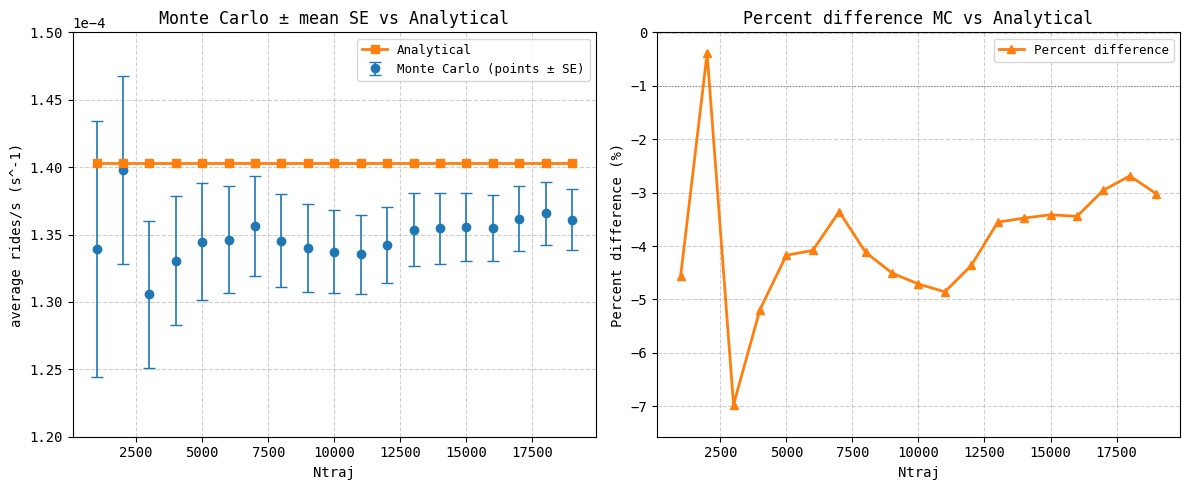

In [ ]:
plt.rcParams['font.family'] = 'monospace'

sim_vec = np.array(list(range(1000, 20000, 1000)))  # Ntraj values
mc_vec = []
mc_std_vec = []
an_vec = []

for N in sim_vec:
    res_mc = simulate_ctmc_montecarlo(Ntraj=int(N), rng_seed=42)
    mc_vec.append(res_mc['mean_rides_per_s'])
    mc_std_vec.append(res_mc['std_rides_per_s'])
    an_vec.append(rides_bar)

mc_vec = np.array(mc_vec, dtype=float)
mc_std_vec = np.array(mc_std_vec, dtype=float)
an_vec = np.array(an_vec, dtype=float)

# ----------------------------
# Convert sample std -> standard error on the mean (SE)
# ----------------------------
# SE = sample_std / sqrt(Ntraj)
SE_vec = mc_std_vec / np.sqrt(sim_vec)

# ----------------------------
# Derived diagnostics for more informative plotting
# ----------------------------
# percent difference (useful because absolute rates are very small)
# guard for division by zero in analytical values:
with np.errstate(divide='ignore', invalid='ignore'):
    pct_diff = 100.0 * (mc_vec - an_vec) / np.where(np.abs(an_vec) > 0, an_vec, np.nan)

# z-score (how many SEs the difference is)
z_scores = (mc_vec - an_vec) / SE_vec
# handle possible nan/inf if SE_vec == 0
z_scores = np.where(np.isfinite(z_scores), z_scores, np.nan)

# ----------------------------
# Plotting
# ----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: means with standard-error bars (smaller, informative)
ax1.errorbar(sim_vec, mc_vec,
             yerr=SE_vec,
             fmt='o',
             capsize=4,
             elinewidth=1.2,
             markeredgewidth=1.0,
             label='Monte Carlo (points ± SE)',
             zorder=5)
ax1.plot(sim_vec, an_vec, 's-', label='Analytical', linewidth=2, zorder=10)

# Improve numeric readability: scientific notation for small rates
ax1.ticklabel_format(axis='y', style='sci', scilimits=( -4, 4 ))  # adjust limits to your preference
ax1.set_xlabel('Ntraj')
ax1.set_ylabel(r'average rides/s (s^-1)')
ax1.set_title('Monte Carlo ± mean SE vs Analytical')
ax1.legend(fontsize=9)
ax1.grid(True, linestyle='dashed', alpha=0.6)
ax1.set_ylim(1.2e-4, 1.5e-4)

# Optionally zoom y-limits around the means + a few SEs instead of letting huge raw std dominate.
# # Compute a tight y window: [min(mean - k*SE), max(mean + k*SE)] with small margin
# k = 3.0
# ymin = np.nanmin(mc_vec - k * SE_vec)
# ymax = np.nanmax(mc_vec + k * SE_vec)
# yrange = ymax - ymin
# if np.isfinite(yrange) and yrange > 0:
#     ax1.set_ylim(ymin - 0.15 * yrange, ymax + 0.15 * yrange)

# Right: percent difference (more interpretable for tiny absolute rates)
ax2.plot(sim_vec, pct_diff, '^-', color='C1', linewidth=2, zorder=10, label='Percent difference')
ax2.axhline(0.0, color='black', lw=1.0, linestyle='--', zorder=5)
# reference bands for practical significance
ax2.axhline(1.0, color='gray', lw=0.8, linestyle=':', zorder=3)
ax2.axhline(-1.0, color='gray', lw=0.8, linestyle=':', zorder=3)
ax2.axhline(5.0, color='lightgray', lw=0.8, linestyle=':', zorder=3)
ax2.axhline(-5.0, color='lightgray', lw=0.8, linestyle=':', zorder=3)
ax2.set_xlabel('Ntraj')
ax2.set_ylabel('Percent difference (%)')
ax2.set_title('Percent difference MC vs Analytical')
ax2.legend(fontsize=9)
ax2.grid(True, linestyle='dashed', alpha=0.6)
current_ymin, _ = ax2.get_ylim()  # keep current ymin
ax2.set_ylim(current_ymin, 0.0)

# for i, N in enumerate(sim_vec):
#     if np.isfinite(z_scores[i]):
#         y_offset = 0.2 * ((-1) ** i)  # alternates up/down
#         ax2.text(N, pct_diff[i] + y_offset, f"z={z_scores[i]:.2f}",
#                  fontsize=8, fontfamily='monospace', va='bottom', ha='center', zorder=30)

plt.tight_layout()
plt.show()
